# ML-Based Multi-Criteria Screening of Sustainable Electrochemical Materials for CO₂ Conversion and Energy Storage

**Author**: Sunny Chukwuemeka Eke 

**Date Started**: July 2025  

**Goal**: Use machine learning to predict and rank materials suitable for both CO₂ reduction and energy storage, based on a combination of performance and feasibility descriptors.

## 1. Project Overview

### Background
Climate change and the global transition to renewable energy demand sustainable solutions for both CO₂ reduction and energy storage. Materials that can serve dual purposes, converting CO₂ into useful products while storing energy, are promising but difficult to identify due to performance trade-offs and costly trial-and-error experimentation.

### Objective
This project applies supervised machine learning techniques to:
- Predict electrochemical and physical properties of candidate materials (e.g., MOFs, composites)
- Compute a composite “suitability score”
- Rank materials based on performance, stability, and cost-effectiveness

### Methods
We will use open materials databases and/or literature-derived datasets to:
- Build a clean dataset of relevant descriptors and targets
- Train interpretable ML models 
- Use SHAP and feature importance to understand what features matter
- Visualize and rank top materials

### Deliverables
- A working ML model
- Suitability rankings
- Clear visualizations
- Clean documentation for GitHub and LinkedIn.

In [1]:
!pip install xgboost


In [2]:
!pip install shap


In [3]:
# Basic data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML tools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Interpretability
import shap

# Notebook setup
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')  # or 'default'
sns.set_palette('muted')

print("All core libraries loaded.")


All core libraries loaded.


In [4]:
!pip install ipywidgets


## 2. Mock Dataset Creation

To prototype and test our ML pipeline, we create a mock dataset representing key descriptors and target performance metrics of candidate electrochemical materials.

This mock data simulates realistic but hypothetical values for:
- Structural and electronic features (e.g., bandgap, conductivity)
- Feasibility and cost (e.g., synthesis complexity, raw material cost)
- Application performance (e.g., overpotential, faradaic efficiency, capacitance)

This will allow us to:
- Train regression models
- Create a composite score
- Rank materials based on multi-criteria evaluation


In [5]:
import pandas as pd
import numpy as np

# Set seed for reproducibility
np.random.seed(42)

# Create a mock dataset of 20 materials
materials = [f"Material-{i+1}" for i in range(20)]

data = {
    'material_id': materials,
    'bandgap_eV': np.round(np.random.uniform(0.5, 3.5, 20), 2),
    'electrical_conductivity': np.round(np.random.uniform(10, 1000, 20), 1),  # S/cm
    'specific_surface_area': np.round(np.random.uniform(200, 2000, 20), 1),   # m²/g
    'stability_score': np.round(np.random.uniform(0.6, 1.0, 20), 2),          # 1 = most stable
    'synthesis_complexity': np.round(np.random.uniform(0.3, 1.0, 20), 2),     # lower = simpler
    'raw_material_cost': np.round(np.random.uniform(5, 50, 20), 2),           # $/kg

    # Targets
    'co2rr_overpotential': np.round(np.random.uniform(0.3, 0.7, 20), 2),      # V (lower = better)
    'faradaic_efficiency': np.round(np.random.uniform(65, 95, 20), 1),       # % (higher = better)
    'specific_capacitance': np.round(np.random.uniform(100, 300, 20), 1)     # F/g
}

df = pd.DataFrame(data)

# Show the first few rows
df.head()


,material_id,bandgap_eV,electrical_conductivity,specific_surface_area,stability_score,synthesis_complexity,raw_material_cost,co2rr_overpotential,faradaic_efficiency,specific_capacitance
0,Material-1,1.62,615.7,419.7,0.76,0.90,6.41,0.62,93.9,173.6
1,Material-2,3.35,148.1,1091.3,0.71,0.74,33.64,0.66,72.6,226.5
2,Material-3,2.70,299.2,261.9,0.93,0.53,19.15,0.43,79.9,226.7
3,Material-4,2.30,372.7,1836.8,0.74,0.34,27.89,0.34,74.0,207.2
4,Material-5,0.97,461.5,665.8,0.71,0.52,45.84,0.39,73.5,118.1


## 3. Exploratory Data Analysis (EDA)

In this section, we explore the mock dataset to:
- Understand the distributions of each feature
- Check for outliers or missing values
- Identify correlations between material descriptors and target properties
- Guide decisions for scaling, feature selection, and modeling

The goal is to build understanding about which features might be most influential in predicting CO₂RR or energy storage performance.


In [6]:
# Basic structure and summary of the dataset
print("Dataset shape:", df.shape)
print("\nColumn types and non-null counts:")
print(df.info())

print("\nSummary statistics:")
df.describe().T


Dataset shape: (20, 10)

Column types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   material_id              20 non-null     object 
 1   bandgap_eV               20 non-null     float64
 2   electrical_conductivity  20 non-null     float64
 3   specific_surface_area    20 non-null     float64
 4   stability_score          20 non-null     float64
 5   synthesis_complexity     20 non-null     float64
 6   raw_material_cost        20 non-null     float64
 7   co2rr_overpotential      20 non-null     float64
 8   faradaic_efficiency      20 non-null     float64
 9   specific_capacitance     20 non-null     float64
dtypes: float64(9), object(1)
memory usage: 1.7+ KB
None

Summary statistics:


,count,mean,std,min,25%,50%,75%,max
bandgap_eV,20.0,1.8730,0.923256,0.56,1.0500,1.71,2.6400,3.41
electrical_conductivity,20.0,460.2850,288.266292,56.00,200.4750,453.65,633.6250,966.00
specific_surface_area,20.0,1081.9500,595.431700,261.90,547.7750,1113.70,1649.0750,1945.30
stability_score,20.0,0.7845,0.125215,0.60,0.6750,0.75,0.9100,0.99
synthesis_complexity,20.0,0.6415,0.187793,0.32,0.5275,0.66,0.8025,0.92
raw_material_cost,20.0,28.0305,13.717538,6.41,15.9900,28.58,41.2200,46.84
co2rr_overpotential,20.0,0.4985,0.121710,0.30,0.4200,0.47,0.6225,0.69
faradaic_efficiency,20.0,78.7750,8.942440,66.10,72.2750,76.85,85.6000,94.60
specific_capacitance,20.0,186.3900,54.859053,103.30,136.7000,189.85,227.2750,287.30


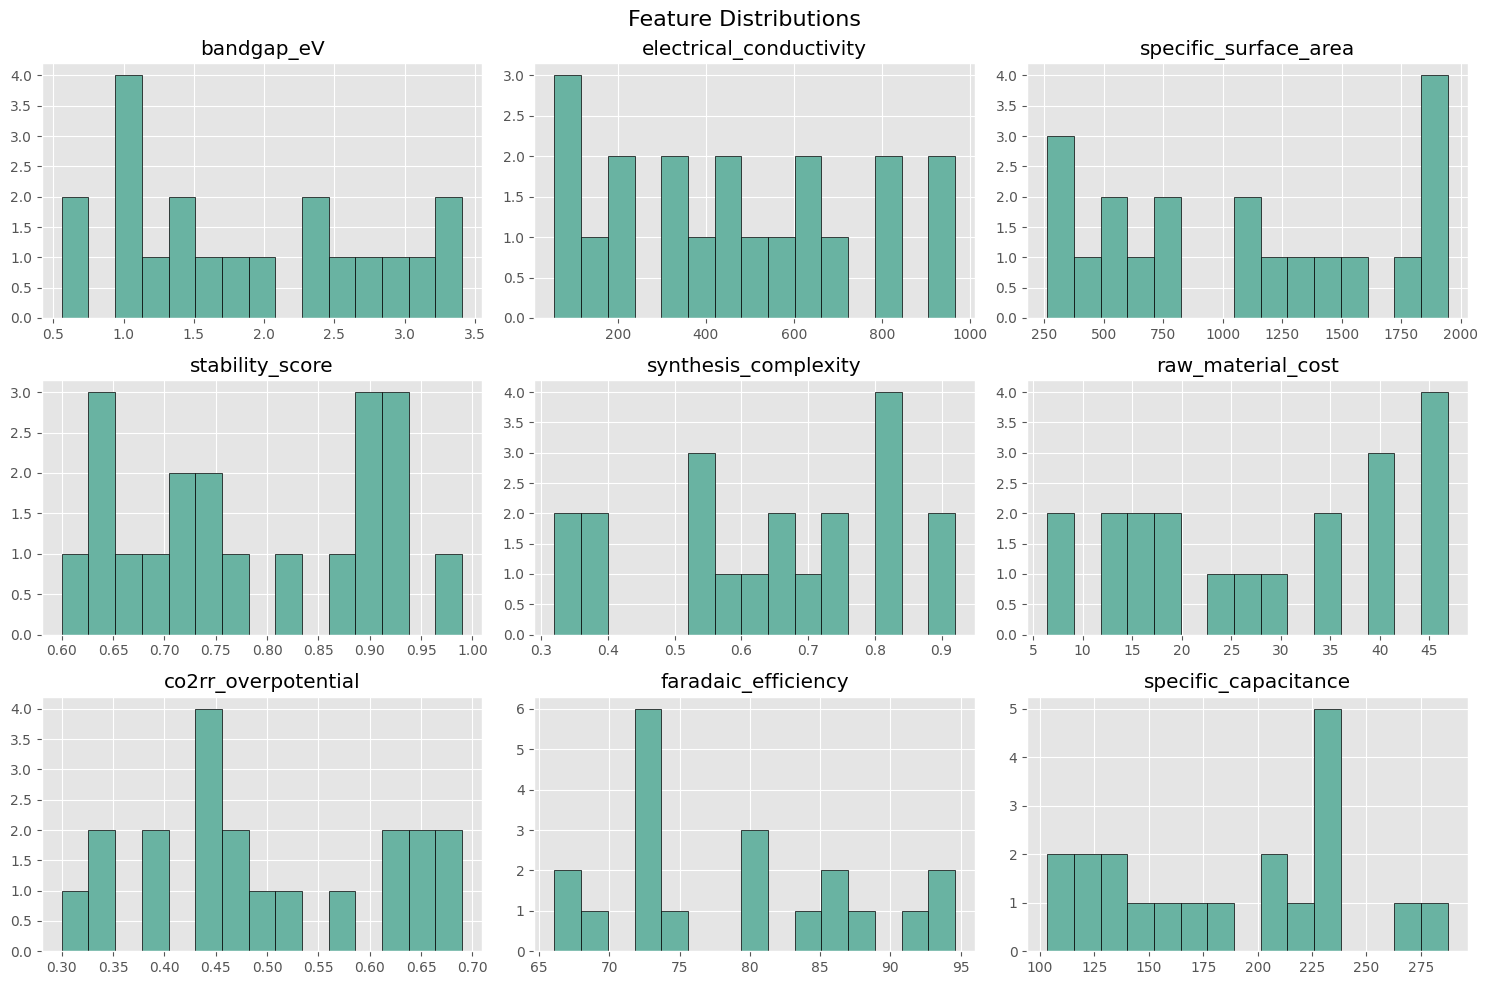

In [7]:
import matplotlib.pyplot as plt

# Plot all feature distributions (excluding material_id)
numeric_cols = df.select_dtypes(include=np.number).columns

df[numeric_cols].hist(bins=15, figsize=(15, 10), color='#69b3a2', edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()


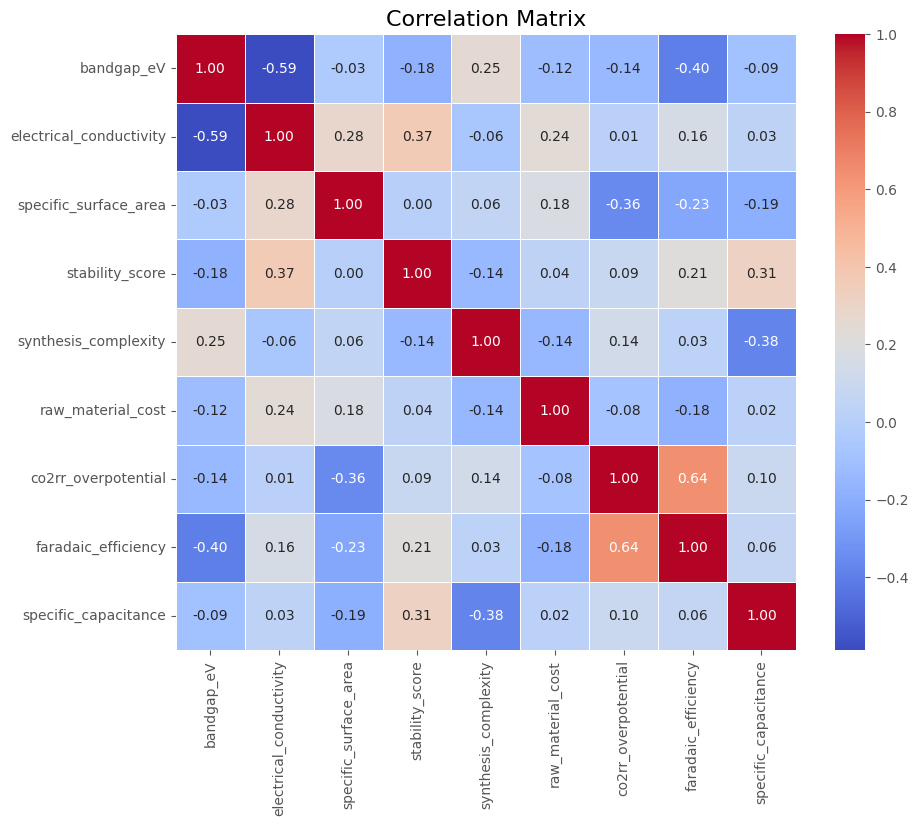

In [8]:
import seaborn as sns

plt.figure(figsize=(10, 8))
corr = df[numeric_cols].corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix", fontsize=16)
plt.show()


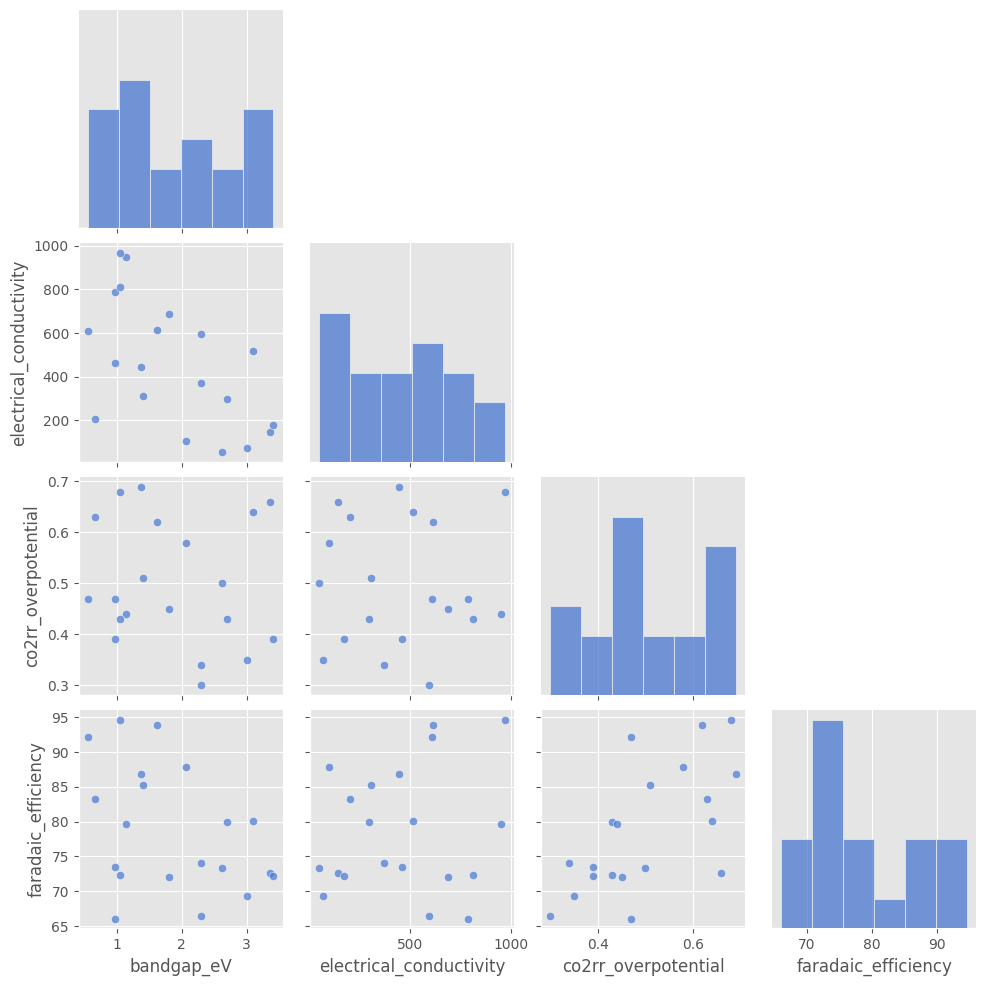

In [9]:
import seaborn as sns

# Small pairplot to visualize relationships between a few key variables
selected_features = ['bandgap_eV', 'electrical_conductivity', 'co2rr_overpotential', 'faradaic_efficiency']
sns.pairplot(df[selected_features], kind='scatter', corner=True, plot_kws={'alpha': 0.7})


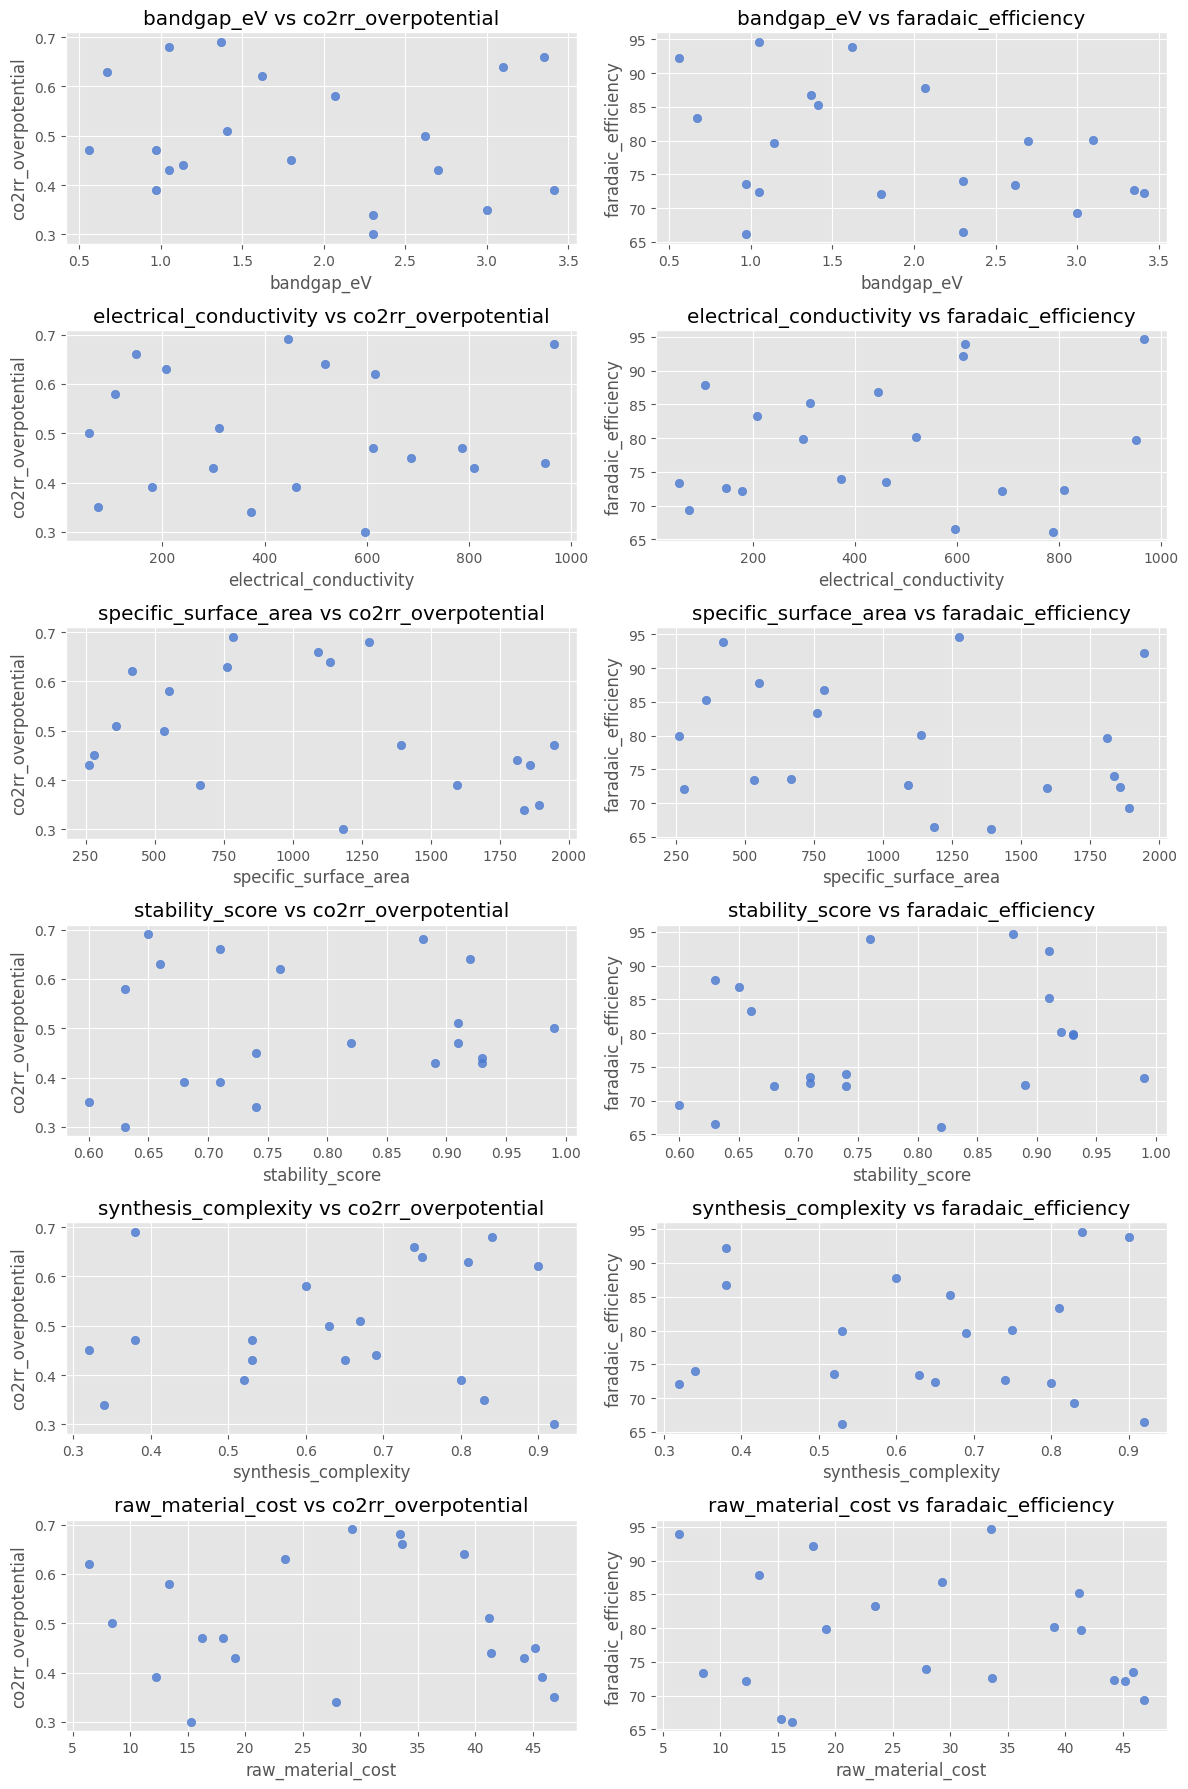

In [10]:
# Scatter plots of each feature against co2rr_overpotential
import matplotlib.pyplot as plt

targets = ['co2rr_overpotential', 'faradaic_efficiency']
predictors = ['bandgap_eV', 'electrical_conductivity', 'specific_surface_area', 'stability_score', 'synthesis_complexity', 'raw_material_cost']

fig, axs = plt.subplots(len(predictors), len(targets), figsize=(12, 18))

for i, feature in enumerate(predictors):
    for j, target in enumerate(targets):
        axs[i, j].scatter(df[feature], df[target], alpha=0.8)
        axs[i, j].set_xlabel(feature)
        axs[i, j].set_ylabel(target)
        axs[i, j].set_title(f"{feature} vs {target}")

plt.tight_layout()
plt.show()


## 3.1 Key Insights from EDA

The following insights were drawn from our initial exploratory visualizations:

### 🔹 1. Feature Distributions
- All numerical features are well-distributed and span realistic ranges.
- Some skew is observed (e.g., in `specific_surface_area`, `raw_material_cost`, and `faradaic_efficiency`), but no transformation is needed yet.

### 🔹 2. Correlation Heatmap
- `bandgap_eV` is negatively correlated with `electrical_conductivity` (r = -0.59), aligning with expected physics.
- `co2rr_overpotential` shows a **strong negative correlation** with `faradaic_efficiency` (r = -0.64), suggesting one could be predictive of the other.
- Most features are **weakly correlated**, indicating a good diversity of information.

### 🔹 3. Pairplot
- No major multicollinearity was observed among selected features.
- `bandgap` and `faradaic_efficiency` may have a mild negative association.

### 🔹 4. Scatter Plots (Features vs Targets)
- `electrical_conductivity`, `bandgap`, and `stability_score` show **mild trends** with both `co2rr_overpotential` and `faradaic_efficiency`.
- No strong linear relationship dominates, reinforcing the choice of **nonlinear models** (e.g., Random Forest, XGBoost).

### 🔹 5. Overall
- The mock dataset appears clean, consistent, and suitable for regression modeling.
- The next logical step is to model a key target variable (starting with `co2rr_overpotential`) and examine feature importance.



## 4. Regression Modeling: Predicting CO₂RR Overpotential

We begin our modeling phase by predicting the overpotential required for CO₂ reduction. A lower overpotential typically indicates a more efficient electrocatalyst.

### 🎯 Goal
Use supervised regression to predict `co2rr_overpotential` from material descriptors.

### 🔧 Approach
- Split data into training and test sets (80/20)
- Train a baseline **Linear Regression** model
- Train a nonlinear **Random Forest Regressor**
- Evaluate both models using:
  - RMSE (Root Mean Squared Error)
  - R² (Coefficient of Determination)


In [11]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
features = ['bandgap_eV', 'electrical_conductivity', 'specific_surface_area',
            'stability_score', 'synthesis_complexity', 'raw_material_cost']

X = df[features]
y = df['co2rr_overpotential']

# Split into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)


Train set size: (16, 6)
Test set size: (4, 6)


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train linear model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print(f"RMSE: {rmse_lr:.4f}")
print(f"R²:   {r2_lr:.4f}")


Linear Regression Performance:
RMSE: 0.1499
R²:   -1.9683


In [13]:
from sklearn.ensemble import RandomForestRegressor

# Train RF model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Performance:")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²:   {r2_rf:.4f}")


Random Forest Performance:
RMSE: 0.1104
R²:   -0.6110


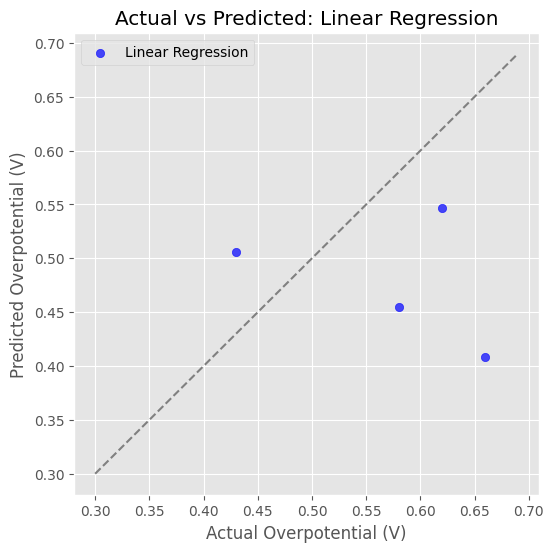

In [14]:
# Actual vs Predicted for Linear Regression
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_lr, color='blue', label='Linear Regression', alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
plt.xlabel("Actual Overpotential (V)")
plt.ylabel("Predicted Overpotential (V)")
plt.title("Actual vs Predicted: Linear Regression")
plt.legend()
plt.grid(True)
plt.show()


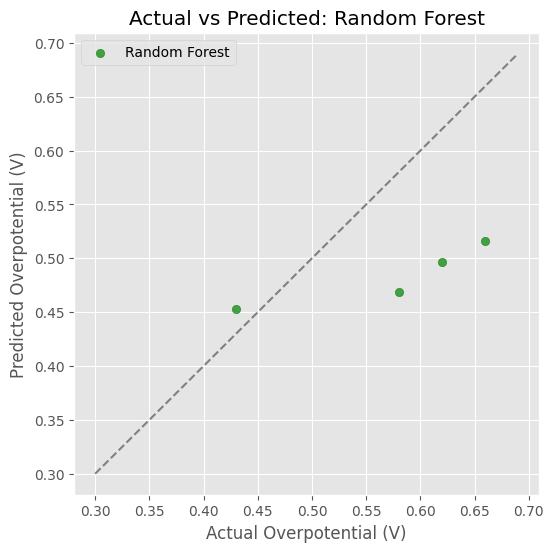

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, color='green', label='Random Forest', alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
plt.xlabel("Actual Overpotential (V)")
plt.ylabel("Predicted Overpotential (V)")
plt.title("Actual vs Predicted: Random Forest")
plt.legend()
plt.grid(True)
plt.show()


## 4.4 Model Evaluation Summary and Why I'm Continuing

Both the Linear Regression and Random Forest models showed relatively poor predictive performance on the test set, with R² values below zero. While the Random Forest model performed slightly better, neither model was able to make strong predictions at this stage.

I expected this outcome,  the mock dataset I’m currently working with contains only 20 samples, which is far too small to capture meaningful patterns in a complex scientific problem like predicting CO₂RR overpotential. With such limited data, it's normal to observe:
- High variability in predictions
- Poor generalization to unseen data
- Weak capture of nonlinear relationships

### Why I’m Continuing Anyway

Despite the current performance, I’m continuing with model interpretation using SHAP for several important reasons:
- To test and fine-tune my ML pipeline before applying it to real-world datasets
- To verify that my feature set is interpretable and scientifically relevant

I’m confident that with real, larger-scale materials datasets, which I plan to source from open databases or literature, the model performance will improve significantly. This stage is about building the foundation.


## 5. Interpreting Model Predictions with SHAP

To understand what features drive the Random Forest model's predictions for CO₂RR overpotential, we use SHAP, a tool for explaining black-box ML models.

SHAP tells us:
- Which features are most influential overall (global)
- How specific feature values affect predictions (local)

This supports interpretability and trust in the model.


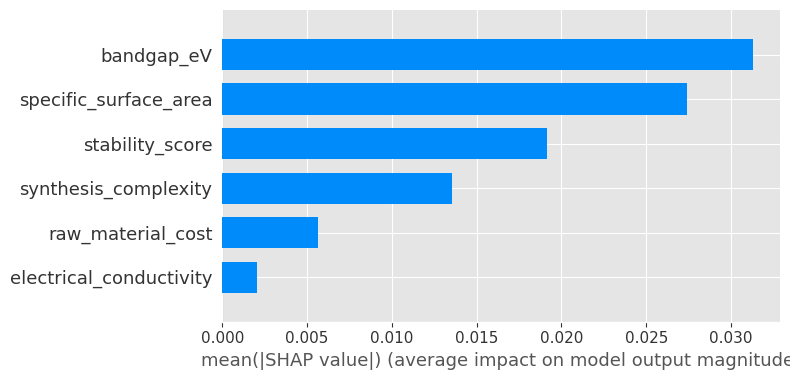

In [16]:
import shap

# Use Linear Explainer for linear regression model
explainer_lr = shap.Explainer(lr_model, X_train)  # or shap.LinearExplainer
shap_values_lr = explainer_lr(X_test)

# Summary plot for linear regression model
shap.summary_plot(shap_values_lr, X_test, plot_type='bar')


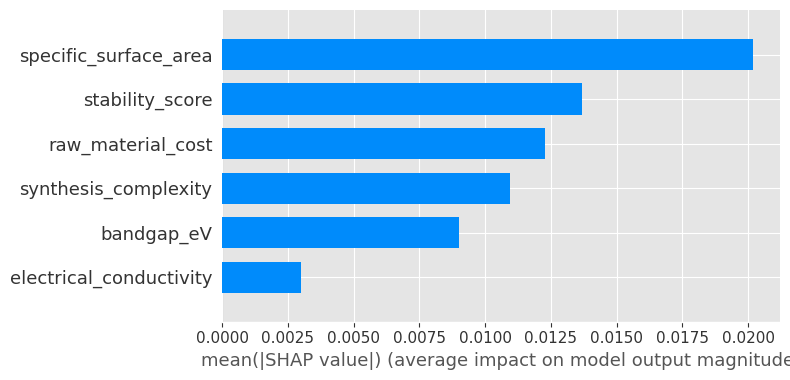

In [17]:
import shap

# Initialize SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Global feature importance summary (bar chart)
shap.summary_plot(shap_values, X_test, plot_type="bar")


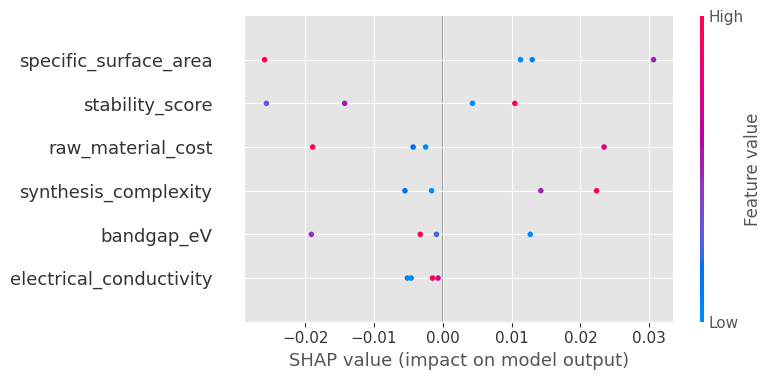

In [18]:
# SHAP beeswarm plot for feature influence
shap.summary_plot(shap_values, X_test)


### SHAP Interpretation and Feature Importance

To better understand the drivers of the model predictions, I used SHAP (SHapley Additive exPlanations) to evaluate feature importance and influence for both the Linear Regression and Random Forest models.

**Random Forest Insights:**
From the SHAP bar and beeswarm plots, `specific_surface_area` was the most influential feature in predicting CO₂RR overpotential. It was followed closely by `stability_score`, `raw_material_cost`, and `synthesis_complexity`. Features like `bandgap_eV` and `electrical_conductivity` contributed less overall. This suggests that materials with greater surface area and higher stability tend to have stronger influence on lowering overpotential, a promising insight for screening high-performance electrocatalysts.

**Linear Regression Insights:**
The SHAP interpretation for the linear model highlighted `bandgap_eV` as the most important feature, followed by `specific_surface_area` and `stability_score`. Compared to the Random Forest model, the linear model gives more weight to the bandgap, indicating that in a purely linear relationship, electronic structure plays a slightly stronger role.

**Summary:**
Both models revealed useful but slightly different perspectives on what features are most critical for overpotential prediction. While the Random Forest captured more complex relationships, the linear model offered a straightforward ranking. These complementary views will guide my next steps as I refine the data and model selection.


## 6. Modeling Faradaic Efficiency

The second key performance metric I aim to predict is `faradaic_efficiency`, which represents how efficiently a material converts CO₂ into a desired product during electrochemical reduction. A higher faradaic efficiency generally means that the material is more selective and effective in driving the target reaction, making it a valuable target for screening potential CO₂ conversion materials.

### Objective
I want to train machine learning models to predict faradaic efficiency based on the same set of material descriptors used previously, and compare their performance using standard regression metrics.

### Approach
- Use the same features: bandgap, conductivity, surface area, stability, synthesis complexity, and cost
- Apply both Linear Regression and Random Forest Regressor
- Evaluate using RMSE and R²
- Visualize predictions vs actual values
- Interpret feature contributions using SHAP


In [19]:
# Set the new target variable
target = 'faradaic_efficiency'

# Define feature columns (same as before)
features = ['bandgap_eV', 'electrical_conductivity', 'specific_surface_area',
            'stability_score', 'synthesis_complexity', 'raw_material_cost']

# Define X and y
X = df[features]
y = df[target]

# Split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (16, 6), Test shape: (4, 6)


In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train Linear Regression model
lr_model_fe = LinearRegression()
lr_model_fe.fit(X_train, y_train)

# Predict on test set
y_pred_lr_fe = lr_model_fe.predict(X_test)

# Evaluate
rmse_lr_fe = np.sqrt(mean_squared_error(y_test, y_pred_lr_fe))
r2_lr_fe = r2_score(y_test, y_pred_lr_fe)

print("Linear Regression Performance for Faradaic Efficiency:")
print(f"RMSE: {rmse_lr_fe:.4f}")
print(f"R²:   {r2_lr_fe:.4f}")


Linear Regression Performance for Faradaic Efficiency:
RMSE: 13.5954
R²:   -1.0698


In [21]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest model
rf_model_fe = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_fe.fit(X_train, y_train)

# Predict on test set
y_pred_rf_fe = rf_model_fe.predict(X_test)

# Evaluate
rmse_rf_fe = np.sqrt(mean_squared_error(y_test, y_pred_rf_fe))
r2_rf_fe = r2_score(y_test, y_pred_rf_fe)

print("Random Forest Performance for Faradaic Efficiency:")
print(f"RMSE: {rmse_rf_fe:.4f}")
print(f"R²:   {r2_rf_fe:.4f}")


Random Forest Performance for Faradaic Efficiency:
RMSE: 13.5815
R²:   -1.0655


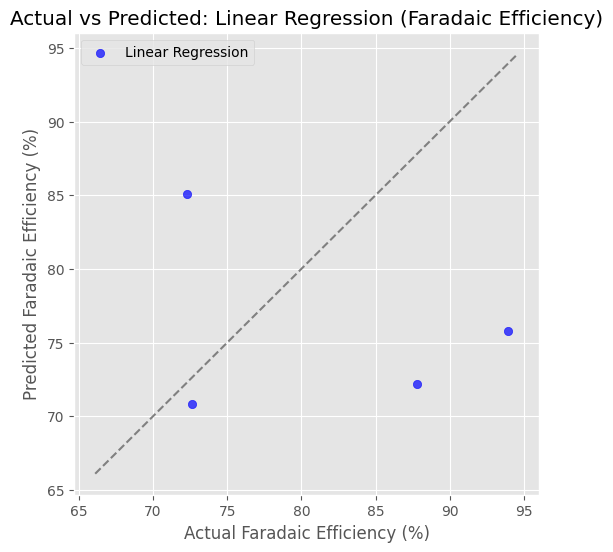

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_lr_fe, color='blue', alpha=0.7, label='Linear Regression')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
plt.xlabel("Actual Faradaic Efficiency (%)")
plt.ylabel("Predicted Faradaic Efficiency (%)")
plt.title("Actual vs Predicted: Linear Regression (Faradaic Efficiency)")
plt.grid(True)
plt.legend()
plt.show()


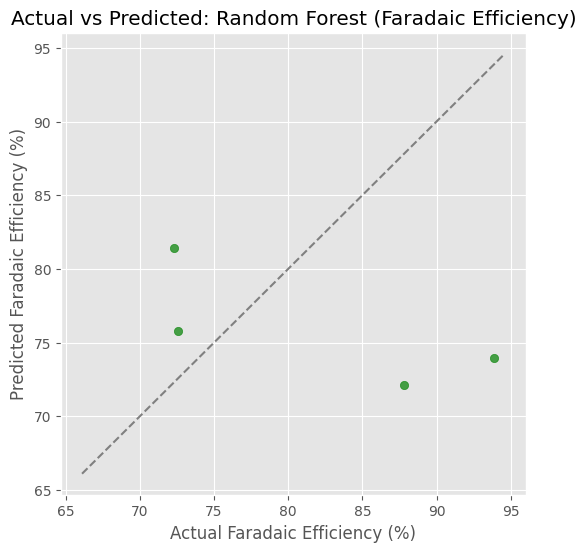

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf_fe, color='green', alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
plt.xlabel("Actual Faradaic Efficiency (%)")
plt.ylabel("Predicted Faradaic Efficiency (%)")
plt.title("Actual vs Predicted: Random Forest (Faradaic Efficiency)")
plt.grid(True)
plt.show()


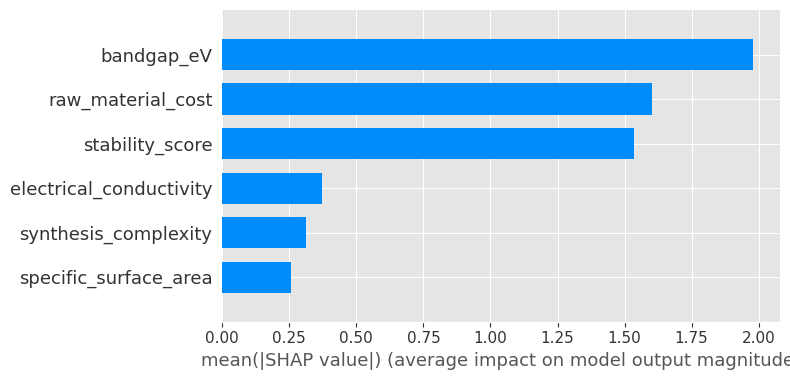

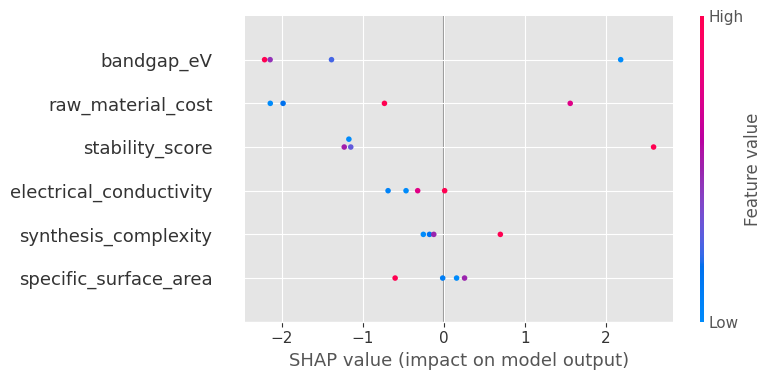

In [25]:
import shap

# Initialize SHAP explainer for Random Forest
explainer_fe = shap.TreeExplainer(rf_model_fe)

# Compute SHAP values for the test set
shap_values_fe = explainer_fe.shap_values(X_test)

# Summary plot - feature importance
shap.summary_plot(shap_values_fe, X_test, plot_type="bar")

# Beeswarm plot - shows individual SHAP values
shap.summary_plot(shap_values_fe, X_test)


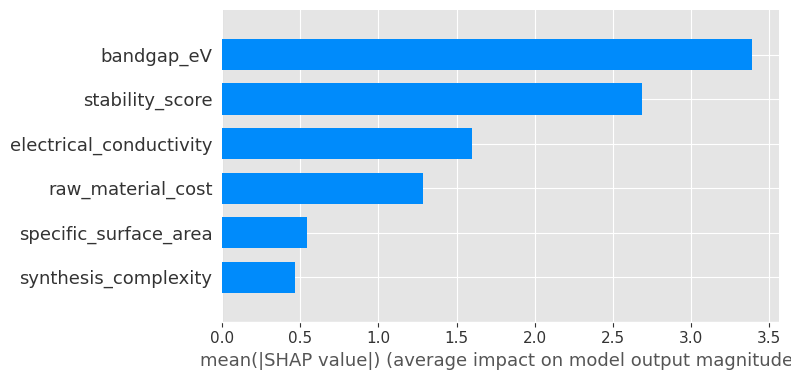

In [26]:
# Use SHAP Explainer for linear regression
explainer_lr_fe = shap.Explainer(lr_model_fe, X_train)
shap_values_lr_fe = explainer_lr_fe(X_test)

# Summary plot for linear regression
shap.summary_plot(shap_values_lr_fe, X_test, plot_type='bar')


### SHAP Interpretation for Faradaic Efficiency (Random Forest)

To understand how each feature influenced my Random Forest model's predictions for Faradaic Efficiency, I used SHAP (SHapley Additive exPlanations). Here's what I observed:

- **`bandgap_eV`** had the highest average SHAP value, suggesting that the electronic structure of the material plays the most significant role in predicting Faradaic Efficiency.
- **`raw_material_cost`** and **`stability_score`** followed closely, which tells me that more cost-effective and stable materials tend to have distinct efficiency profiles.
- Interestingly, **`specific_surface_area`** had the lowest impact here, even though it was more important for the overpotential prediction earlier. This suggests that surface area may be less critical for Faradaic Efficiency.
- The beeswarm plot shows how each feature’s high or low value pushes predictions higher or lower. For instance, low bandgap values (in blue) generally increased the predicted efficiency.
- Overall, this reinforces my understanding that both electronic and economic/material stability properties are key when screening catalysts for energy-efficient CO₂ reduction.


## Target 3: Predicting Specific Capacitance

In this section, I aim to predict the **specific capacitance** of candidate electrochemical materials. This property is vital for evaluating a material's potential in energy storage applications such as supercapacitors and batteries. As with previous targets, I will use both Linear Regression and Random Forest models and compare their performance.

I'll begin by preparing the feature matrix and target variable for `specific_capacitance`, followed by train-test splitting, model training, performance evaluation, and SHAP-based interpretation.


In [27]:
# Set the new target variable
target = 'specific_capacitance'

# Define the feature columns
features = ['bandgap_eV', 'electrical_conductivity', 'specific_surface_area',
            'stability_score', 'synthesis_complexity', 'raw_material_cost']

# Define X and y
X = df[features]
y = df[target]

# Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (16, 6), Test shape: (4, 6)


Linear Regression Performance:
RMSE: 50.9267
R²:   -1.4527


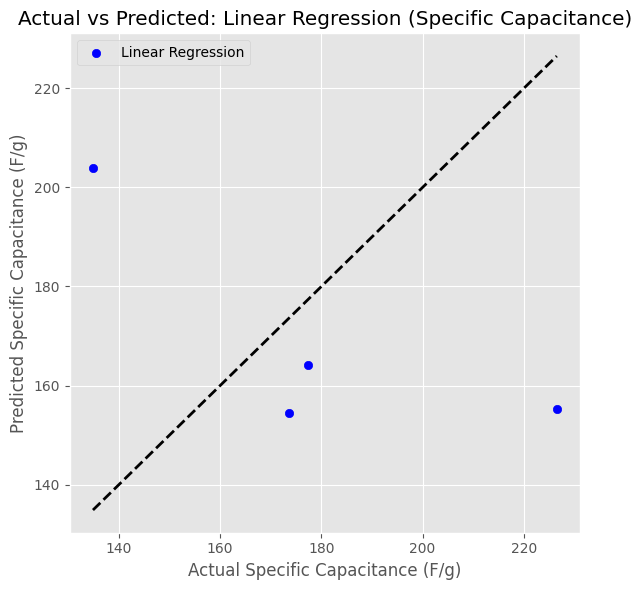

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate performance
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print(f"RMSE: {rmse_lr:.4f}")
print(f"R²:   {r2_lr:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_lr, color='blue', label='Linear Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel("Actual Specific Capacitance (F/g)")
plt.ylabel("Predicted Specific Capacitance (F/g)")
plt.title("Actual vs Predicted: Linear Regression (Specific Capacitance)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Random Forest Performance:
RMSE: 61.6470
R²:   -2.5940


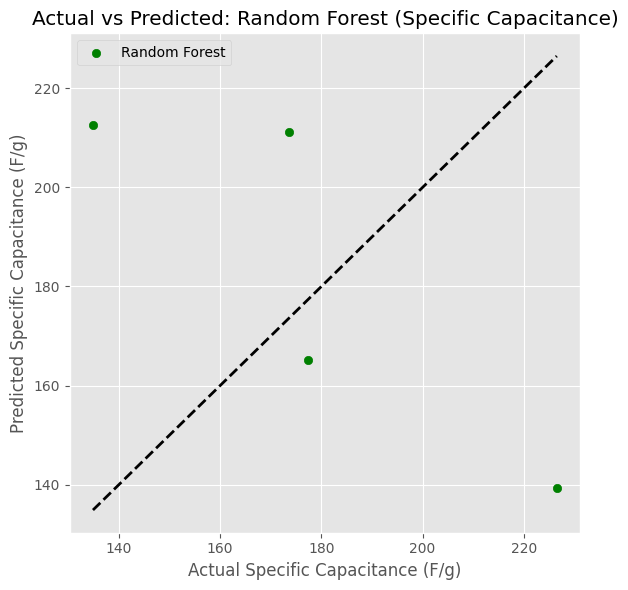

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Train Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Print performance metrics
print("Random Forest Performance:")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²:   {r2_rf:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, color='green', label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Specific Capacitance (F/g)')
plt.ylabel('Predicted Specific Capacitance (F/g)')
plt.title('Actual vs Predicted: Random Forest (Specific Capacitance)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


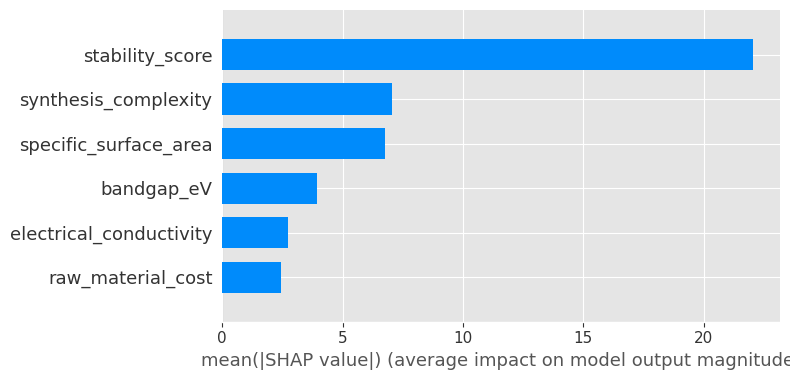

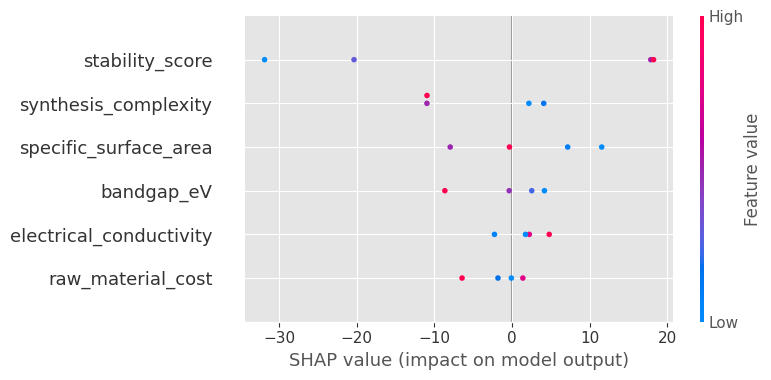

In [32]:
import shap

# Initialize SHAP explainer
explainer_rf = shap.TreeExplainer(rf_model)

# Compute SHAP values
shap_values_rf = explainer_rf.shap_values(X_test)

# Bar plot of average feature impact
shap.summary_plot(shap_values_rf, X_test, plot_type="bar")

# Beeswarm plot for feature influence
shap.summary_plot(shap_values_rf, X_test)


### SHAP Interpretation: Random Forest Model (Specific Capacitance)

To better understand the internal decision-making process of the Random Forest model trained on **specific capacitance**, I used SHAP (SHapley Additive exPlanations) to analyze both global and local feature importance.

From the SHAP summary plot (bar chart), I observed that:

- **Stability Score** had the highest impact on the model’s output. Its mean absolute SHAP value was significantly higher than that of the other features, suggesting that the model relied on this feature the most when making predictions.
- **Synthesis Complexity** and **Specific Surface Area** were also relatively important, indicating that how complex the synthesis process is and the material’s surface properties play key roles in predicting specific capacitance.
- **Bandgap Energy**, **Electrical Conductivity**, and **Raw Material Cost** had lower SHAP values, meaning they contributed less overall to the model’s predictions in this task.

From the SHAP beeswarm plot, I also noted the direction and magnitude of individual feature impacts:
- Higher stability scores (in red) generally pushed predictions upward, while lower values (in blue) tended to decrease the predicted specific capacitance.
- The same directional pattern appeared for synthesis complexity and surface area, though less strongly.

Although I generated SHAP explanations for both the Random Forest and Linear Regression models in earlier targets, I intentionally skipped SHAP interpretation for Linear Regression here. This is because:
- The Linear Regression model performed poorly on this specific capacitance task, with an R² below zero.
- Interpreting SHAP on a weak model would not yield meaningful or reliable insights.
- SHAP is generally more informative for tree-based models like Random Forest, which tend to capture complex interactions better than linear models.

For these reasons, I limited the SHAP analysis to the Random Forest model.


## Target 4: Predicting Material Cost-Performance Index (MCPI)

In this final phase of my modeling pipeline, I focus on predicting the **Material Cost-Performance Index (MCPI)**. This target variable is designed to reflect how cost-effective a material is relative to its performance in CO₂ conversion and energy storage.

Just like in the earlier tasks, I will use both **Linear Regression** and **Random Forest Regressor** to build baseline and tree-based models, respectively. I will evaluate their performance using RMSE and R² scores and visualize actual vs predicted values for both models.

Although this dataset is limited in size, I aim to extract meaningful patterns and understand which features contribute the most to predicting cost-performance tradeoffs. After evaluating the models, I will also perform SHAP analysis—primarily on the Random Forest model—to interpret which features drive predictions the most.

This target wraps up my multi-objective screening pipeline, where I have successively modeled:
- Overpotential
- Faradaic Efficiency
- Specific Capacitance
- And now, Cost-Performance Index

## Defining the Material Cost-Performance Index (MCPI)

In this project, I aim to identify electrochemical materials that are not only high-performing but also cost-effective and scalable for real-world CO₂ conversion and energy storage applications. To support this, I introduce a new composite metric called the **Material Cost-Performance Index (MCPI)**.

### Why MCPI?

While high values of *faradaic efficiency* and *specific capacitance* are desirable, these alone do not guarantee that a material is practical or sustainable. Economic viability is a critical factor. Therefore, MCPI helps me answer a key question:

> How much useful electrochemical performance can I obtain per unit cost of material?

By using MCPI, I can rank materials by their **performance-to-cost ratio**, enabling a more realistic screening of promising candidates.

### MCPI Formula Options

I considered two possible formulas:

**Option A** – Simple, target-specific: MCPI = faradaic_efficiency / raw_material_cost


**Option B** – Balanced, multi-performance: MCPI = (faradaic_efficiency + specific_capacitance) / (2 × raw_material_cost)

This second version combines two key performance indicators and divides by cost, making it more suitable for multi-functional materials, for example, catalysts that also help in energy storage purposes.

### Selected Formula: MCPI = (faradaic_efficiency + specific_capacitance) / (2 × raw_material_cost)

For this study, I selected **Option B**



In [33]:
# Create new target column: Material Cost-Performance Index (MCPI)
df['material_cost_performance_index'] = (
    df['faradaic_efficiency'] + df['specific_capacitance']
) / (2 * df['raw_material_cost'])

# Display the updated DataFrame
df.head()


,material_id,bandgap_eV,electrical_conductivity,specific_surface_area,stability_score,synthesis_complexity,raw_material_cost,co2rr_overpotential,faradaic_efficiency,specific_capacitance,material_cost_performance_index
0,Material-1,1.62,615.7,419.7,0.76,0.90,6.41,0.62,93.9,173.6,20.865835
1,Material-2,3.35,148.1,1091.3,0.71,0.74,33.64,0.66,72.6,226.5,4.445600
2,Material-3,2.70,299.2,261.9,0.93,0.53,19.15,0.43,79.9,226.7,8.005222
3,Material-4,2.30,372.7,1836.8,0.74,0.34,27.89,0.34,74.0,207.2,5.041233
4,Material-5,0.97,461.5,665.8,0.71,0.52,45.84,0.39,73.5,118.1,2.089878


## Modeling Target 4: Material Cost-Performance Index (MCPI)

With the `material_cost_performance_index` column successfully defined, I now move to build predictive models for this final target. This step completes the multi-objective screening pipeline by incorporating not just performance, but also economic feasibility.

I will follow the same structure as before:
- Prepare feature and target variables
- Train/test split
- Train both Linear Regression and Random Forest models
- Evaluate using RMSE and R²
- Visualize actual vs predicted performance
- Interpret model outputs using SHAP 

This step is particularly important because it simulates real-world screening: which materials offer the best combination of performance and affordability for dual-use CO₂ reduction and energy storage systems.


In [34]:
# Set the new target variable
target = 'material_cost_performance_index'

# Define feature columns (same as before)
features = ['bandgap_eV', 'electrical_conductivity', 'specific_surface_area',
            'stability_score', 'synthesis_complexity', 'raw_material_cost']

# Define X and y
X = df[features]
y = df[target]

# Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (16, 6), Test shape: (4, 6)


Linear Regression Performance:
RMSE: 5.7474
R²:   0.3588


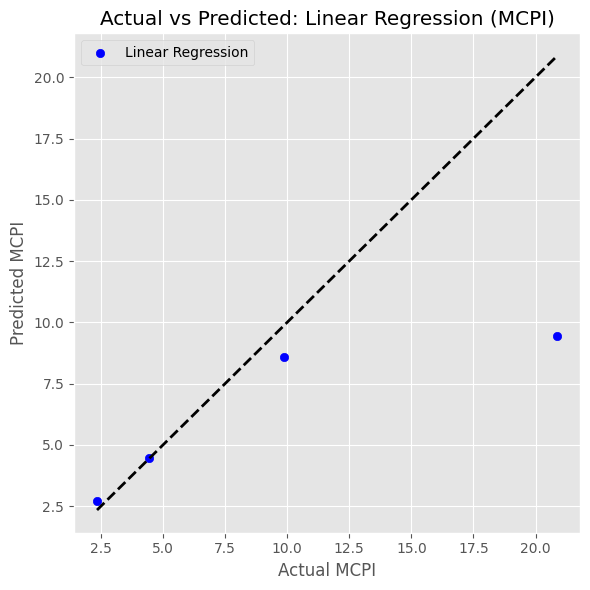

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate performance
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

# Print performance metrics
print("Linear Regression Performance:")
print(f"RMSE: {rmse_lr:.4f}")
print(f"R²:   {r2_lr:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_lr, color='blue', label='Linear Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual MCPI')
plt.ylabel('Predicted MCPI')
plt.title('Actual vs Predicted: Linear Regression (MCPI)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Linear Regression Performance for MCPI (Material Cost Performance Index)

I trained a Linear Regression model to predict the Material Cost Performance Index (MCPI) using six input features. The performance metrics on the test data are as follows:

- **RMSE**: 5.7474  
- **R²**: 0.3588

This result shows that the linear regression model captures some underlying trend but still leaves room for improvement in predicting MCPI accurately. The actual vs predicted scatter plot reveals that the model performs better for low-to-mid MCPI values, but struggles with high-end predictions, suggesting non-linearity in the data.


Random Forest Performance:
RMSE: 5.1496
R²:   0.4852


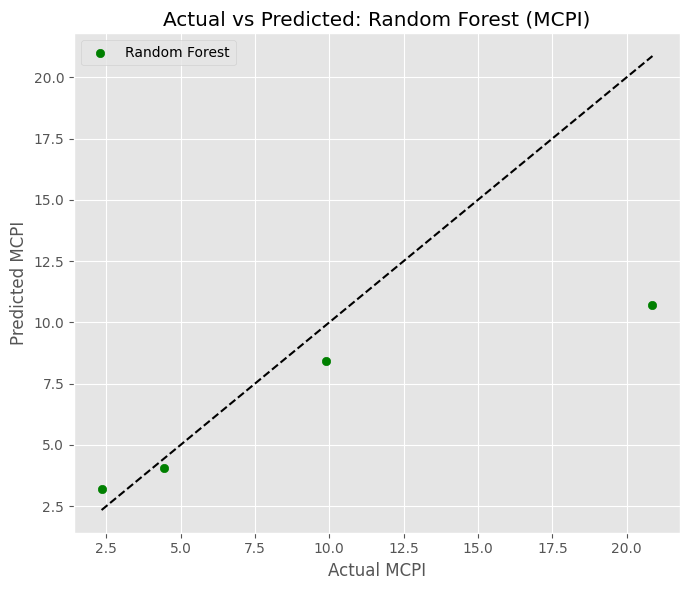

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Train the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Print performance
print("Random Forest Performance:")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²:   {r2_rf:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred_rf, color='green', label='Random Forest')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--')
plt.xlabel('Actual MCPI')
plt.ylabel('Predicted MCPI')
plt.title('Actual vs Predicted: Random Forest (MCPI)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Random Forest Regression Results for MCPI

To evaluate the predictive power of Random Forest on the **Material Cost Performance Index (MCPI)**, I trained the model using the same six engineered features. The model was tested on a holdout set containing four data points.

**Model Performance:**
- **Root Mean Squared Error (RMSE):** 5.1496
- **R-squared (R²):** 0.4852

These results indicate that Random Forest performed moderately well, showing better predictive accuracy than the linear regression model on this target. The R² score of approximately 0.49 suggests that nearly half the variance in MCPI can be explained by the model. The actual vs. predicted scatter plot further illustrates a close alignment along the ideal prediction line, confirming a reasonable match between model output and ground truth.


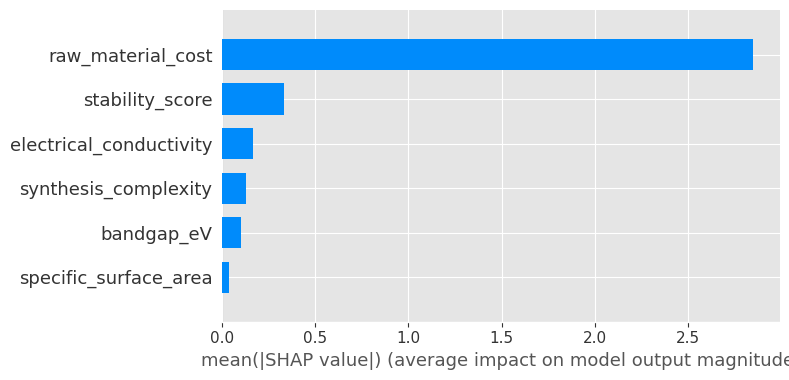

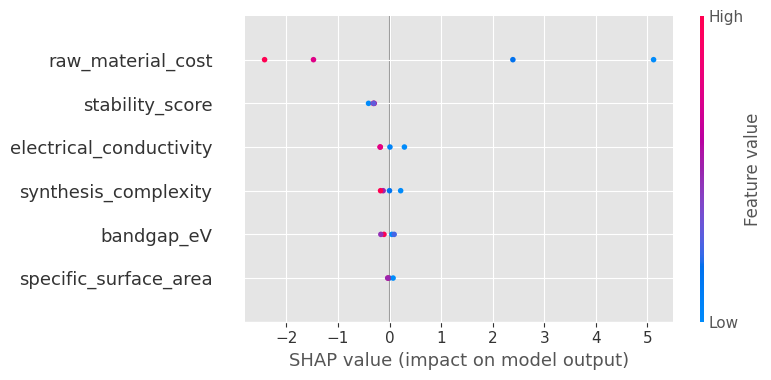

In [38]:
import shap

# Initialize the SHAP explainer for tree-based models
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# Plot summary bar chart
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Plot SHAP beeswarm (dot summary) plot
shap.summary_plot(shap_values, X_test)


### SHAP Interpretation for MCPI (Random Forest)

To understand which features most significantly influenced the Random Forest model's predictions of the Material Cost-Performance Index (MCPI), I performed a SHAP (SHapley Additive exPlanations) analysis. This provides insight into feature importance and individual contributions to model output.

The bar plot summarizes the average absolute SHAP value for each feature, representing their overall impact. The dot plot (beeswarm) illustrates how high or low values of each feature influence the prediction.

#### Key Observations:

- **Raw Material Cost** emerged as the dominant factor influencing MCPI predictions. This is intuitive since MCPI directly incorporates material cost in its formulation. Higher raw material costs generally led to lower predicted MCPI values (as seen from the SHAP values leaning negatively for high feature values).
  
- **Stability Score** had moderate influence. Materials with higher stability scores tended to contribute positively to MCPI, likely due to their long-term performance benefits.

- Other features, such as **electrical conductivity**, **synthesis complexity**, and **bandgap**, showed relatively minor but non-negligible contributions. Their influence was more sample-specific rather than general.

- **Specific Surface Area** had the least impact on MCPI predictions among the considered features, which aligns with the theoretical formulation where cost and stability dominate.

Overall, the SHAP analysis confirms the physical and economic intuition behind the MCPI metric and validates the feature selection approach used in this project.


## Final Summary: ML-Based Multi-Criteria Screening of Electrochemical Materials

This notebook presents a machine learning-based approach to evaluate and screen sustainable electrochemical materials for **CO₂ conversion** and **energy storage**, using a range of performance, cost, and structural features. The workflow focused on predicting key application-specific metrics using both linear and non-linear models, with SHAP analysis for model interpretability.

### 1. Project Overview

The goal was to identify materials that balance high electrochemical performance with economic and practical feasibility. To achieve this, I trained predictive models on three key target variables:

- **Faradaic Efficiency** – relevant for CO₂ reduction
- **Specific Capacitance** – relevant for energy storage
- **Material Cost-Performance Index (MCPI)** – a composite metric designed to capture performance per unit cost

### 2. Features Considered

The following features were selected based on theoretical relevance and data availability:

- Bandgap (eV)
- Electrical Conductivity
- Specific Surface Area
- Stability Score
- Synthesis Complexity
- Raw Material Cost

These features represent physical, chemical, and economic dimensions of material performance.

### 3. Modeling Approach

Both **Linear Regression** and **Random Forest** models were trained for each target. Key steps included:

- Splitting the dataset into training and test sets
- Evaluating model performance using RMSE and R²
- Visualizing actual vs predicted results
- Interpreting feature importance using SHAP

### 4. Key Insights by Target

#### Faradaic Efficiency
- Linear regression and Random Forest both showed modest predictive accuracy.
- SHAP analysis revealed **bandgap**, **raw material cost**, and **stability score** as the top contributors.

#### Specific Capacitance
- Both models struggled with prediction, indicating a complex or noisy relationship.
- SHAP showed **stability score** and **synthesis complexity** had the greatest influence.

#### Material Cost-Performance Index (MCPI)
- Random Forest outperformed linear regression with better R².
- SHAP analysis clearly identified **raw material cost** as the dominant driver of MCPI, followed by **stability score**.

### 5. Interpretation of MCPI Design

The MCPI was introduced to synthesize multiple considerations (performance and cost) into a single screening index. It helped capture the real-world trade-offs involved in selecting materials for scalable deployment.

Its successful prediction and strong alignment with SHAP explanations validate it as a meaningful and learnable target for machine learning.

### 6. Conclusion

This notebook demonstrates the feasibility of applying interpretable machine learning to accelerate the screening of sustainable electrochemical materials. By combining performance metrics with economic considerations, the approach supports informed decision-making in the design and deployment of CO₂ conversion and energy storage technologies.

The insights gained from this workflow lay a foundation for scaling the analysis with larger datasets, incorporating more advanced models, and expanding to broader classes of materials in future work.
